---
## **`dlt` resources**

---
### List of dicts


In the previous lesson, we simply used a list of dictionaries that essentially represents the `pokemon` table.



In [1]:
import dlt

# Sample data containing pokemon details
data = [
    {"id": "1", "name": "bulbasaur", "size": {"weight": 6.9, "height": 0.7}},
    {"id": "4", "name": "charmander", "size": {"weight": 8.5, "height": 0.6}},
    {"id": "25", "name": "pikachu", "size": {"weight": 6, "height": 0.4}},
]


# Set pipeline name, destination, and dataset name
pipeline = dlt.pipeline(
    pipeline_name="quick_start",
    destination="duckdb",
    dataset_name="mydata",
)

# Run the pipeline with data and table name
load_info = pipeline.run(data, table_name="pokemon")

print(load_info)

2024-12-27 15:34:11,408|[WARNING]|47428|8416710464|dlt|configuration.py|_path_from_pipeline:178|Duckdb attached to pipeline quick_start in path quick_start.duckdb was could not be found but pipeline has already ran. This may be a result of (1) recreating or attaching pipeline  without or with changed explicit path to database that was used when creating the pipeline. (2) keeping the path to to database in secrets and changing the current working folder so  dlt cannot see them. (3) you deleting the database.


Pipeline quick_start load step completed in 0.06 seconds
1 load package(s) were loaded to destination duckdb and into dataset mydata
The duckdb destination used duckdb:////Users/m/code/dlt_course/quick_start.duckdb location to store data
Load package 1735310051.4616551 is LOADED and contains no failed jobs


A better way is to wrap it in the `@dlt.resource` decorator which denotes a logical grouping of data within a data source, typically holding data of similar structure and origin:

In [2]:
import dlt

# Create a dlt resource from the data
@dlt.resource(table_name='pokemon_new') # <--- we set new table name
def my_dict_list():
    yield data

Commonly used arguments:

* **`name`**: The resource name and the name of the table generated by this resource. Defaults to the decorated function name.
* **`table_name`**: the name of the table, if different from the resource name.
* **`write_disposition`**: controls how to write data to a table. Defaults to "append".

> **Why is it a better way?** This allows you to use `dlt` functionalities to the fullest that follow Data Engineering best practices, including incremental loading and data contracts.

Try running the pipeline with the my_dict_list resource:


In [3]:
# Run the pipeline and print load info
load_info = pipeline.run(my_dict_list)
print(load_info)

Pipeline quick_start load step completed in 0.04 seconds
1 load package(s) were loaded to destination duckdb and into dataset mydata
The duckdb destination used duckdb:////Users/m/code/dlt_course/quick_start.duckdb location to store data
Load package 1735311026.163569 is LOADED and contains no failed jobs


Check what was loaded to the `pokemon_new` table:

In [4]:
pipeline.dataset(dataset_type="default").pokemon_new.df()

,id,name,size__weight,size__height,_dlt_load_id,_dlt_id
0,1,bulbasaur,6.9,0.7,1735311026.163569,H8+bdTXD3lYgwg
1,4,charmander,8.5,0.6,1735311026.163569,ZoK0Da6E9IvKaA
2,25,pikachu,6.0,0.4,1735311026.163569,SX21ArFjDmvzVQ


Instead of a dict list, the data could also be a/an:
- dataframe
- database query response
- API request response
- Anything you can transform into JSON/dict format

---
### Dataframes
For creating a pipeline using dataframes, you would do:

In [5]:
import pandas as pd

# Define a resource to load data from a CSV
@dlt.resource(table_name='df_data')
def my_df():
  sample_df = pd.read_csv("https://people.sc.fsu.edu/~jburkardt/data/csv/hw_200.csv")
  yield sample_df


# Run the pipeline with the defined resource
load_info = pipeline.run(my_df)
print(load_info)

# Query the loaded data from 'df_data'
pipeline.dataset(dataset_type="default").df_data.df()

Pipeline quick_start load step completed in 0.05 seconds
1 load package(s) were loaded to destination duckdb and into dataset mydata
The duckdb destination used duckdb:////Users/m/code/dlt_course/quick_start.duckdb location to store data
Load package 1735311569.376041 is LOADED and contains no failed jobs


,index,height_inchesx,_weight_poundsx
0,1,65.78,112.99
1,2,71.52,136.49
2,3,69.40,153.03
3,4,68.22,142.34
4,5,67.79,144.30
...,...,...,...
195,196,65.80,120.84
196,197,66.11,115.78
197,198,68.24,128.30
198,199,68.02,127.47


In [6]:
new_df = pd.read_csv("https://people.sc.fsu.edu/~jburkardt/data/csv/hw_200.csv")

In [7]:
new_df.head()

,Index,"Height(Inches)""","""Weight(Pounds)"""
0,1,65.78,112.99
1,2,71.52,136.49
2,3,69.40,153.03
3,4,68.22,142.34
4,5,67.79,144.30


---
### Database

For creating a pipeline from an SQL database query you would do:

1. Install the PyMySQL package:

In [ ]:
%%capture
uv add pymysql

2. Create and run a pipeline to fetch data from an SQL resource and query the loaded data as follows:

In [10]:
import dlt
from sqlalchemy import create_engine

# Define a resource to fetch genome data from the database
@dlt.resource(table_name='genome_data')
def get_genome_data():
  engine = create_engine("mysql+pymysql://rfamro@mysql-rfam-public.ebi.ac.uk:4497/Rfam")
  with engine.connect() as conn:
      query = "SELECT * FROM genome LIMIT 1000"
      rows = conn.execution_options(yield_per=100).exec_driver_sql(query)
      yield from map(lambda row: dict(row._mapping), rows)

# Run the pipeline with the genome data resource
load_info = pipeline.run(get_genome_data)
print(load_info)

# Query the loaded data from 'genome_data'
pipeline.dataset(dataset_type="default").genome_data.df()

Pipeline quick_start load step completed in 0.16 seconds
1 load package(s) were loaded to destination duckdb and into dataset mydata
The duckdb destination used duckdb:////Users/m/code/dlt_course/quick_start.duckdb location to store data
Load package 1735312042.8845701 is LOADED and contains no failed jobs


,upid,description,total_length,ncbi_id,scientific_name,kingdom,num_rfam_regions,num_families,is_reference,is_representative,...,assembly_acc,assembly_version,assembly_level,ungapped_length,assembly_name,study_ref,circular,wgs_acc,wgs_version,common_name
0,RG000000001,Potato spindle tuber viroid,4591,12892,Potato spindle tuber viroid,viroids,0,0,1,0,...,None,NaN,None,NaN,None,None,NaN,None,NaN,None
1,RG000000002,Columnea latent viroid,370,12901,Columnea latent viroid,viroids,0,0,1,0,...,None,NaN,None,NaN,None,None,NaN,None,NaN,None
2,RG000000003,Tomato apical stunt viroid-S,360,53194,Tomato apical stunt viroid-S,viroids,0,0,1,0,...,None,NaN,None,NaN,None,None,NaN,None,NaN,None
3,RG000000004,Tomato apical stunt viroid,360,12885,Tomato apical stunt viroid,viroids,0,0,1,0,...,None,NaN,None,NaN,None,None,NaN,None,NaN,None
4,RG000000005,Cucumber yellows virus,7899,32618,Cucumber yellows virus,viruses,0,0,1,0,...,None,NaN,None,NaN,None,None,NaN,None,NaN,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,UP000001264,None,40275,673838,Enterococcus phage phiFL3B,viruses,0,0,0,1,...,GCA_002630665.1,1.0,complete-genome,NaN,ASM263066v1,None,NaN,None,NaN,None
996,UP000001265,Enterococcus phage phiFL4A,37856,673839,Enterococcus phage phiFL4A,viruses,2,2,0,1,...,,0.0,,0.0,,,0.0,,0.0,
997,UP000001266,Staphylococcus phage SA1,147303,694060,Staphylococcus phage SA1,viruses,0,0,0,1,...,,0.0,,0.0,,,0.0,,0.0,
998,UP000001270,Mycobacterium phage AnnaL29,53253,1076630,Mycobacterium phage AnnaL29,viruses,0,0,0,1,...,,0.0,,0.0,,,0.0,,0.0,


---
### REST API

For REST API endpoints, create a pipeline as follows:

In [11]:
from dlt.sources.helpers import requests


# Define a resource to fetch pokemons from PokeAPI
@dlt.resource(table_name='pokemon_api')
def get_pokemon():
    url = "https://pokeapi.co/api/v2/pokemon"
    response = requests.get(url)
    yield response.json()["results"]


# Run the pipeline using the defined resource
load_info = pipeline.run(get_pokemon)
print(load_info)

# Query the loaded data from 'pokemon_api' table
pipeline.dataset(dataset_type="default").pokemon_api.df()

Pipeline quick_start load step completed in 0.05 seconds
1 load package(s) were loaded to destination duckdb and into dataset mydata
The duckdb destination used duckdb:////Users/m/code/dlt_course/quick_start.duckdb location to store data
Load package 1735312302.8235662 is LOADED and contains no failed jobs


,name,url,_dlt_load_id,_dlt_id
0,bulbasaur,https://pokeapi.co/api/v2/pokemon/1/,1735312302.8235662,unqTi3MIV5pe6w
1,ivysaur,https://pokeapi.co/api/v2/pokemon/2/,1735312302.8235662,LbMvYHZ8ES275Q
2,venusaur,https://pokeapi.co/api/v2/pokemon/3/,1735312302.8235662,DLsz2GtaCGyeZA
3,charmander,https://pokeapi.co/api/v2/pokemon/4/,1735312302.8235662,lGMa0/TqC3wA6w
4,charmeleon,https://pokeapi.co/api/v2/pokemon/5/,1735312302.8235662,loebgI2DVegXbA
5,charizard,https://pokeapi.co/api/v2/pokemon/6/,1735312302.8235662,UGRujkQKIcp+qw
6,squirtle,https://pokeapi.co/api/v2/pokemon/7/,1735312302.8235662,xxA6L6eHxiswrA
7,wartortle,https://pokeapi.co/api/v2/pokemon/8/,1735312302.8235662,zUF/yyxPMLOFqQ
8,blastoise,https://pokeapi.co/api/v2/pokemon/9/,1735312302.8235662,5EeUROWEugLmvQ
9,caterpie,https://pokeapi.co/api/v2/pokemon/10/,1735312302.8235662,HBeAFOODp82LWg


Try loading everything above, in a single pipeline:

In [14]:
load_info = pipeline.run([my_df, get_genome_data, get_pokemon])
print(load_info)

2024-12-27 16:13:57,833|[WARNING]|47428|8416710464|dlt|configuration.py|_path_from_pipeline:178|Duckdb attached to pipeline quick_start in path quick_start.duckdb was could not be found but pipeline has already ran. This may be a result of (1) recreating or attaching pipeline  without or with changed explicit path to database that was used when creating the pipeline. (2) keeping the path to to database in secrets and changing the current working folder so  dlt cannot see them. (3) you deleting the database.


Pipeline quick_start load step completed in 0.17 seconds
1 load package(s) were loaded to destination duckdb and into dataset mydata
The duckdb destination used duckdb:////Users/m/code/dlt_course/quick_start.duckdb location to store data
Load package 1735312434.185596 is LOADED and contains no failed jobs


Check which new tables were created:

In [15]:
# List all table names from the database
with pipeline.sql_client() as client:
    with client.execute_query("SELECT table_name FROM information_schema.tables") as table:
        print(table.df())

            table_name
0              df_data
1          genome_data
2          pokemon_api
3           _dlt_loads
4  _dlt_pipeline_state
5         _dlt_version



---
## **`dlt` sources**

Now that there are multiple `dlt` resources, each corresponding to a separate table, we can group them into a `dlt` source.


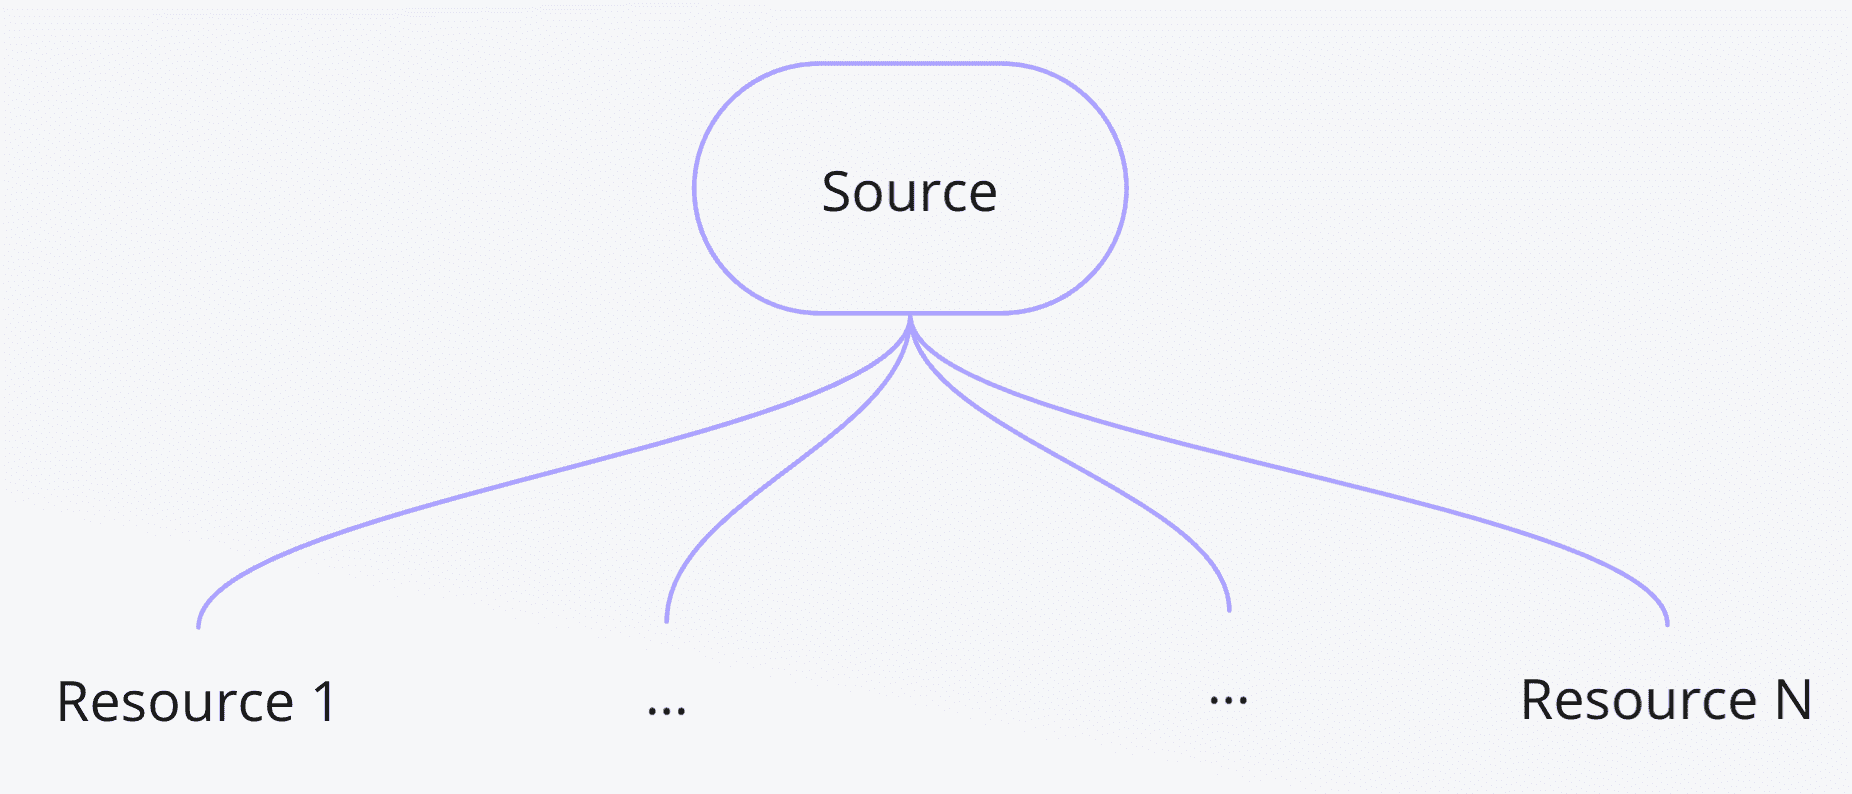

A source is a logical grouping of resources, e.g., endpoints of a single API. The most common approach is to define it in a separate Python module.

* A source is a function decorated with `@dlt.source` that returns one or more resources.
* A source can optionally define a schema with tables, columns, performance hints, and more.
* The source Python module typically contains optional customizations and data transformations.
* The source Python module typically contains the authentication and pagination code for a particular API.

Read more about [sources](https://dlthub.com/docs/general-usage/source) and [resources](https://dlthub.com/docs/general-usage/resource) here.

You declare a source by decorating a function that returns or yields one or more resources with `@dlt.source`.

Here's how it's done:

In [16]:
@dlt.source
def all_data():
  return my_df, get_genome_data, get_pokemon

Only using the source above, load everything into a separate database using a new pipeline:

In [17]:
# Create a pipeline
pipeline = dlt.pipeline(
    pipeline_name="resource_source_new",
    destination="duckdb",
    dataset_name="all_data"
)

# Run the pipeline
load_info = pipeline.run(all_data())

# Print load info
print(load_info)

Pipeline resource_source_new load step completed in 0.17 seconds
1 load package(s) were loaded to destination duckdb and into dataset all_data
The duckdb destination used duckdb:////Users/m/code/dlt_course/resource_source_new.duckdb location to store data
Load package 1735314519.2518039 is LOADED and contains no failed jobs


> **Why does this matter?**:
> - It is more efficient than running your resources separately.
> - It organizes both your schema and your code. 🙂
> - It enables the option for parallelization.

---
## **`dlt` transformers**

We now know that `dlt` resources can be grouped into a `dlt` source, represented as:


```
                  Source
               /          \
          Resource 1  ...  Resource N

```

However, imagine a scenario where you need an additional step in between:

```
                  Source
                 /     \
             step        \
             /             \
        Resource 1  ...  Resource N

```

This step could arise, for example, in a situation where:

- Resource 1 returns a list of pokemons IDs, and you need to use each of those IDs to retrieve detailed information about the pokemons from a separate API endpoint.

In such cases, you would use `dlt` transformers — special `dlt` resources that can be fed data from another resource:

```
                  Source
                 /     \
          Transformer    \
             /             \
        Resource 1  ...  Resource N

```


Let’s assume Resource 1 is:

In [18]:
@dlt.resource(table_name='pokemon')
def my_dict_list():
    yield data

We need to get detailed information about pokemons from [PokeAPI](https://pokeapi.co/) `"https://pokeapi.co/api/v2/pokemon/{id}"` based on their IDs. We would do:

In [19]:
# Define a transformer to enrich pokemon data with additional details
@dlt.transformer(data_from=my_dict_list, table_name='detailed_info')
def poke_details(items): # <--- `items` is a variable and contains data from `my_dict_list` resource
    for item in items:

      print(f"Item: {item}\n") # <-- print what data we get from `my_dict_list` source

      id = item["id"]
      url = f"https://pokeapi.co/api/v2/pokemon/{id}"
      response = requests.get(url)
      details = response.json()

      print(f"Details: {details}\n") # <--- print what data we get from API

      yield details

Run the pipeline:

In [20]:
import requests
load_info = pipeline.run(poke_details())
print(load_info)

Item: {'id': '1', 'name': 'bulbasaur', 'size': {'weight': 6.9, 'height': 0.7}}

Details: {'abilities': [{'ability': {'name': 'overgrow', 'url': 'https://pokeapi.co/api/v2/ability/65/'}, 'is_hidden': False, 'slot': 1}, {'ability': {'name': 'chlorophyll', 'url': 'https://pokeapi.co/api/v2/ability/34/'}, 'is_hidden': True, 'slot': 3}], 'base_experience': 64, 'cries': {'latest': 'https://raw.githubusercontent.com/PokeAPI/cries/main/cries/pokemon/latest/1.ogg', 'legacy': 'https://raw.githubusercontent.com/PokeAPI/cries/main/cries/pokemon/legacy/1.ogg'}, 'forms': [{'name': 'bulbasaur', 'url': 'https://pokeapi.co/api/v2/pokemon-form/1/'}], 'game_indices': [{'game_index': 153, 'version': {'name': 'red', 'url': 'https://pokeapi.co/api/v2/version/1/'}}, {'game_index': 153, 'version': {'name': 'blue', 'url': 'https://pokeapi.co/api/v2/version/2/'}}, {'game_index': 153, 'version': {'name': 'yellow', 'url': 'https://pokeapi.co/api/v2/version/3/'}}, {'game_index': 1, 'version': {'name': 'gold', 'url

Alternatively, we could do:

In [21]:
@dlt.resource(table_name='pokemon')
def my_dict_list():
    yield from data # <--- This would yield one item at a time


@dlt.transformer(data_from=my_dict_list, table_name='detailed_info')
def details(data_item): # <--- Transformer receives one item at a time
    id = data_item["id"]
    url = f"https://pokeapi.co/api/v2/pokemon/{id}"
    response = requests.get(url)
    details = response.json()

    yield details


load_info = pipeline.run(details())
print(load_info)

Pipeline resource_source_new load step completed in 0.30 seconds
1 load package(s) were loaded to destination duckdb and into dataset all_data
The duckdb destination used duckdb:////Users/m/code/dlt_course/resource_source_new.duckdb location to store data
Load package 1735315031.342984 is LOADED and contains no failed jobs


You can also use pipe instead of `data_from`, this is useful when you want to apply `dlt.transformer` to multiple `dlt.resources`:

In [22]:
load_info = pipeline.run(my_dict_list | details)

Check the loaded data:

In [23]:
# Query the 'detailed_info' table and convert the result to a DataFrame
pipeline.dataset(dataset_type="default").detailed_info.df()

,base_experience,cries__latest,cries__legacy,height,id,is_default,location_area_encounters,name,order,species__name,...,sprites__versions__generation_v__black_white__back_shiny_female,sprites__versions__generation_v__black_white__front_female,sprites__versions__generation_v__black_white__front_shiny_female,sprites__versions__generation_vi__omegaruby_alphasapphire__front_female,sprites__versions__generation_vi__omegaruby_alphasapphire__front_shiny_female,sprites__versions__generation_vi__x_y__front_female,sprites__versions__generation_vi__x_y__front_shiny_female,sprites__versions__generation_vii__ultra_sun_ultra_moon__front_female,sprites__versions__generation_vii__ultra_sun_ultra_moon__front_shiny_female,sprites__versions__generation_viii__icons__front_female
0,64,https://raw.githubusercontent.com/PokeAPI/crie...,https://raw.githubusercontent.com/PokeAPI/crie...,7,1,True,https://pokeapi.co/api/v2/pokemon/1/encounters,bulbasaur,1,bulbasaur,...,None,None,None,None,None,None,None,None,None,None
1,62,https://raw.githubusercontent.com/PokeAPI/crie...,https://raw.githubusercontent.com/PokeAPI/crie...,6,4,True,https://pokeapi.co/api/v2/pokemon/4/encounters,charmander,5,charmander,...,None,None,None,None,None,None,None,None,None,None
2,112,https://raw.githubusercontent.com/PokeAPI/crie...,https://raw.githubusercontent.com/PokeAPI/crie...,4,25,True,https://pokeapi.co/api/v2/pokemon/25/encounters,pikachu,35,pikachu,...,https://raw.githubusercontent.com/PokeAPI/spri...,https://raw.githubusercontent.com/PokeAPI/spri...,https://raw.githubusercontent.com/PokeAPI/spri...,https://raw.githubusercontent.com/PokeAPI/spri...,https://raw.githubusercontent.com/PokeAPI/spri...,https://raw.githubusercontent.com/PokeAPI/spri...,https://raw.githubusercontent.com/PokeAPI/spri...,https://raw.githubusercontent.com/PokeAPI/spri...,https://raw.githubusercontent.com/PokeAPI/spri...,https://raw.githubusercontent.com/PokeAPI/spri...
3,64,https://raw.githubusercontent.com/PokeAPI/crie...,https://raw.githubusercontent.com/PokeAPI/crie...,7,1,True,https://pokeapi.co/api/v2/pokemon/1/encounters,bulbasaur,1,bulbasaur,...,None,None,None,None,None,None,None,None,None,None
4,62,https://raw.githubusercontent.com/PokeAPI/crie...,https://raw.githubusercontent.com/PokeAPI/crie...,6,4,True,https://pokeapi.co/api/v2/pokemon/4/encounters,charmander,5,charmander,...,None,None,None,None,None,None,None,None,None,None
5,112,https://raw.githubusercontent.com/PokeAPI/crie...,https://raw.githubusercontent.com/PokeAPI/crie...,4,25,True,https://pokeapi.co/api/v2/pokemon/25/encounters,pikachu,35,pikachu,...,https://raw.githubusercontent.com/PokeAPI/spri...,https://raw.githubusercontent.com/PokeAPI/spri...,https://raw.githubusercontent.com/PokeAPI/spri...,https://raw.githubusercontent.com/PokeAPI/spri...,https://raw.githubusercontent.com/PokeAPI/spri...,https://raw.githubusercontent.com/PokeAPI/spri...,https://raw.githubusercontent.com/PokeAPI/spri...,https://raw.githubusercontent.com/PokeAPI/spri...,https://raw.githubusercontent.com/PokeAPI/spri...,https://raw.githubusercontent.com/PokeAPI/spri...
6,64,https://raw.githubusercontent.com/PokeAPI/crie...,https://raw.githubusercontent.com/PokeAPI/crie...,7,1,True,https://pokeapi.co/api/v2/pokemon/1/encounters,bulbasaur,1,bulbasaur,...,None,None,None,None,None,None,None,None,None,None
7,62,https://raw.githubusercontent.com/PokeAPI/crie...,https://raw.githubusercontent.com/PokeAPI/crie...,6,4,True,https://pokeapi.co/api/v2/pokemon/4/encounters,charmander,5,charmander,...,None,None,None,None,None,None,None,None,None,None
8,112,https://raw.githubusercontent.com/PokeAPI/crie...,https://raw.githubusercontent.com/PokeAPI/crie...,4,25,True,https://pokeapi.co/api/v2/pokemon/25/encounters,pikachu,35,pikachu,...,https://raw.githubusercontent.com/PokeAPI/spri...,https://raw.githubusercontent.com/PokeAPI/spri...,https://raw.githubusercontent.com/PokeAPI/spri...,https://raw.githubusercontent.com/PokeAPI/spri...,https://raw.githubusercontent.com/PokeAPI

---
## **Reduce the nesting level of generated tables**
You can limit how deep dlt goes when generating nested tables and flattening dicts into columns. By default, the library will descend and generate nested tables for all nested lists, without limit.

You can set nesting level for all resources on the source level:

```python
@dlt.source(max_table_nesting=1)
def all_data():
  return my_df, get_genome_data, get_pokemon
```

or for each resource separately:

```python
@dlt.resource(table_name='pokemon_new', max_table_nesting=1)
def my_dict_list():
    yield data
```

In the example above, we want only 1 level of nested tables to be generated (so there are no nested tables of a nested table). Typical settings:

* `max_table_nesting=0` will not generate nested tables and will not flatten dicts into columns at all. All nested data will be represented as JSON.
* `max_table_nesting=1` will generate nested tables of root tables and nothing more. All nested data in nested tables will be represented as JSON.

---
## **Exercise 1: Create a pipeline for GitHub API - repos endpoint**

In this exercise, you'll build a dlt pipeline to fetch data from the GitHub REST API. The goal is to learn how to use `dlt.pipeline`, `dlt.resource`, and `dlt.source` to extract and load data into a destination.

## Instructions

1. **Explore the GitHub API**

  Visit the [GitHub REST API Docs](https://docs.github.com/en/rest) to understand the endpoint to [list public repositories](https://docs.github.com/en/rest/repos/repos?apiVersion=2022-11-28) for an organization:

  GET https://api.github.com/orgs/{org}/repos

2. **Build the Pipeline**

  Write a script to:

  * Fetch repositories for a **dlt-hub** organization.
  * Use `dlt.resource` to define the data extraction logic.
  * Combine all resources to a single `@dlt.source`.
  * Load the data into a DuckDB database.

3. **Look at the data**

  Use `duckdb` connection, `sql_client` or `pipeline.dataset()`.

> **Note**: For this exercise you don't need to use Auth and Pagination.

In [33]:
from dlt.sources.helpers import requests

pipeline = dlt.pipeline(
    pipeline_name="github_pipeline",
    destination="duckdb",
    dataset_name="github_org_data",
    progress="log"
)

# Define a resource to fetch repos from GitHub API
@dlt.resource(table_name='github_repos')
def get_repos():
    org = "dlt-hub"
    url = f"https://api.github.com/orgs/{org}/repos"
    response = requests.get(url)
    yield response.json()

@dlt.source()
def get_all():
    return get_repos


# Run the pipeline using the defined resource
load_info = pipeline.run(get_all())
print(load_info)

# Query the loaded data from 'org_data' table
github_repos_df = pipeline.dataset(dataset_type="default").github_repos.df()

github_repos_df

------------------------------- Extract get_all --------------------------------
Resources: 0/1 (0.0%) | Time: 0.00s | Rate: 0.00/s
Memory usage: 277.73 MB (72.50%) | CPU usage: 0.00%

------------------------------- Extract get_all --------------------------------
Resources: 0/1 (0.0%) | Time: 0.95s | Rate: 0.00/s
github_repos: 30  | Time: 0.00s | Rate: 7401712.94/s
Memory usage: 277.81 MB (72.60%) | CPU usage: 0.00%

------------------------------- Extract get_all --------------------------------
Resources: 1/1 (100.0%) | Time: 0.97s | Rate: 1.03/s
github_repos: 30  | Time: 0.02s | Rate: 1729.61/s
Memory usage: 277.81 MB (72.60%) | CPU usage: 0.00%

-------------------- Normalize get_all in 1735316375.217481 --------------------
Files: 0/1 (0.0%) | Time: 0.00s | Rate: 0.00/s
Memory usage: 277.86 MB (72.60%) | CPU usage: 0.00%

-------------------- Normalize get_all in 1735316375.217481 --------------------
Files: 0/1 (0.0%) | Time: 0.00s | Rate: 0.00/s
Items: 0  | Time: 0.00s | Rate:

,id,node_id,name,full_name,private,owner__login,owner__id,owner__node_id,owner__avatar_url,owner__gravatar_id,...,permissions__admin,permissions__maintain,permissions__push,permissions__triage,permissions__pull,_dlt_load_id,_dlt_id,description,homepage,license__url
0,427664318,R_kgDOGX2jvg,rasa_semantic_schema,dlt-hub/rasa_semantic_schema,False,dlt-hub,89419010,MDEyOk9yZ2FuaXphdGlvbjg5NDE5MDEw,https://avatars.githubusercontent.com/u/894190...,,...,False,False,False,False,True,1735316294.5348191,JMz4igI+dYIczw,None,None,None
1,438622757,R_kgDOGiTaJQ,.github,dlt-hub/.github,False,dlt-hub,89419010,MDEyOk9yZ2FuaXphdGlvbjg5NDE5MDEw,https://avatars.githubusercontent.com/u/894190...,,...,False,False,False,False,True,1735316294.5348191,4KotBsSpEbAWOw,None,None,None
2,452221115,R_kgDOGvRYuw,dlt,dlt-hub/dlt,False,dlt-hub,89419010,MDEyOk9yZ2FuaXphdGlvbjg5NDE5MDEw,https://avatars.githubusercontent.com/u/894190...,,...,False,False,False,False,True,1735316294.5348191,dGEA3Z0LSjO0SQ,data load tool (dlt) is an open source Python ...,https://dlthub.com/docs,https://api.github.com/licenses/apache-2.0
3,462711174,R_kgDOG5Rphg,rasa_semantic_schema_customization,dlt-hub/rasa_semantic_schema_customization,False,dlt-hub,89419010,MDEyOk9yZ2FuaXphdGlvbjg5NDE5MDEw,https://avatars.githubusercontent.com/u/894190...,,...,False,False,False,False,True,1735316294.5348191,z1G6phoIye9Xsg,Template repository to customize and execute R...,,None
4,465315657,R_kgDOG7wnSQ,metabase_data_api,dlt-hub/metabase_data_api,False,dlt-hub,89419010,MDEyOk9yZ2FuaXphdGlvbjg5NDE5MDEw,https://avatars.githubusercontent.com/u/894190...,,...,False,False,False,False,True,1735316294.5348191,czPOdMIOib1lSg,Metabase data api python wrapper for notebooks...,,https://api.github.com/licenses/mit
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,682011011,R_kgDOKKapgw,dlt-dagster-demo,dlt-hub/dlt-dagster-demo,False,dlt-hub,89419010,MDEyOk9yZ2FuaXphdGlvbjg5NDE5MDEw,https://avatars.githubusercontent.com/u/894190...,,...,False,False,False,False,True,1735316375.217481,l+Plx5ctfOFffw,dlt-dagster-demo,None,None
86,688593654,R_kgDOKQsa9g,dlt_demos,dlt-hub/dlt_demos,False,dlt-hub,89419010,MDEyOk9yZ2FuaXphdGlvbjg5NDE5MDEw,https://avatars.githubusercontent.com/u/894190...,,...,False,False,False,False,True,1735316375.217481,uMPEOze25SicGQ,examples how to load data from different sourc...,None,https://api.github.com/licenses/apache-2.0
87,691761197,R_kgDOKTtwLQ,weaviate-verba-demo,dlt-hub/weaviate-verba-demo,False,dlt-hub,89419010,MDEyOk9yZ2FuaXphdGlvbjg5NDE5MDEw,https://avatars.githubusercontent.com/u/894190...,,...,False,False,False,False,True,1735316375.217481,KaZuFuZatJvavw,None,None,None
88,702368174,R_kgDOKd1Jrg,kestra_dlt_blueprints,dlt-hub/kestra_dlt_blueprints,False,dlt-hub,89419010,MDEyOk9yZ2FuaXphdGlvbjg5NDE5MDEw,https://avatars.githubusercontent.com/u/894190...,,...,False,False,False,False,True,1735316375.217481,MyYk9ntnN0EN0g,None,None,None


Play with API using requests library:


In [29]:
import requests
response = requests.get("https://api.github.com/orgs/dlt-hub/repos")
response.json()[0]


{'id': 427664318,
 'node_id': 'R_kgDOGX2jvg',
 'name': 'rasa_semantic_schema',
 'full_name': 'dlt-hub/rasa_semantic_schema',
 'private': False,
 'owner': {'login': 'dlt-hub',
  'id': 89419010,
  'node_id': 'MDEyOk9yZ2FuaXphdGlvbjg5NDE5MDEw',
  'avatar_url': 'https://avatars.githubusercontent.com/u/89419010?v=4',
  'gravatar_id': '',
  'url': 'https://api.github.com/users/dlt-hub',
  'html_url': 'https://github.com/dlt-hub',
  'followers_url': 'https://api.github.com/users/dlt-hub/followers',
  'following_url': 'https://api.github.com/users/dlt-hub/following{/other_user}',
  'gists_url': 'https://api.github.com/users/dlt-hub/gists{/gist_id}',
  'starred_url': 'https://api.github.com/users/dlt-hub/starred{/owner}{/repo}',
  'subscriptions_url': 'https://api.github.com/users/dlt-hub/subscriptions',
  'organizations_url': 'https://api.github.com/users/dlt-hub/orgs',
  'repos_url': 'https://api.github.com/users/dlt-hub/repos',
  'events_url': 'https://api.github.com/users/dlt-hub/events{/pr

In the code snippet below you will find an **example** for **events** endpoint:

In [ ]:
import dlt


# Example resource
@dlt.resource
def github_events():
    url = f"https://api.github.com/orgs/dlt-hub/events"
    response = requests.get(url)
    yield response.json()


# here is your code


# Set pipeline name, destination, and dataset name
pipeline = dlt.pipeline(
    pipeline_name="github_pipeline",
    destination="duckdb",
    dataset_name="github_data"
)

load_info = # here is your code
print(load_info)

### Question
How many columns has the `github_repos` table? Use `duckdb` connection, `sql_client` or `pipeline.dataset()`.

In [34]:
len(github_repos_df.columns)

106

## **Exercise 2: Create a pipeline for GitHub API - stargazers endpoint**

Create a `dlt.transformer` for the "stargazers" endpoint
https://api.github.com/repos/OWNER/REPO/stargazers for `dlt-hub` organization.

Use `github_repos` resource as a main resource for the transformer:
1. Get all `dlt-hub` repositories.
2. Feed these repository names to dlt transformer and get all stargazers for all `dlt-hub` repositories.

In [46]:
from dlt.sources.helpers import requests

pipeline = dlt.pipeline(
    pipeline_name="github_pipeline",
    destination="duckdb",
    dataset_name="github_org_data",
    progress="log"
)

# Define a resource to fetch repos from GitHub API
@dlt.resource(table_name='github_repos')
def get_repos():
    org = "dlt-hub"
    url = f"https://api.github.com/orgs/{org}/repos"
    response = requests.get(url)
    yield response.json()

@dlt.transformer(data_from=get_repos, table_name='github_stargazers')
def github_stargazer(items):
    for item in items:
        print(item)
        owner = item["owner"]["login"]
        print("here")
        repo_name = item["name"]
        print(f"repo_id: {repo_name}")
        url = f"https://api.github.com/repos/{owner}/{repo_name}/stargazers"
        response = requests.get(url)
        details = response.json()

        yield details

# Run the pipeline using the defined resource
load_info = pipeline.run(github_stargazer)
print(load_info)

# Query the loaded data from 'org_data' table
github_stargazers_df = pipeline.dataset(dataset_type="default").github_stargazers.df()

github_stargazers_df

-------------------------------- Extract github --------------------------------
Resources: 0/1 (0.0%) | Time: 0.00s | Rate: 0.00/s
Memory usage: 198.48 MB (72.00%) | CPU usage: 0.00%

{'id': 427664318, 'node_id': 'R_kgDOGX2jvg', 'name': 'rasa_semantic_schema', 'full_name': 'dlt-hub/rasa_semantic_schema', 'private': False, 'owner': {'login': 'dlt-hub', 'id': 89419010, 'node_id': 'MDEyOk9yZ2FuaXphdGlvbjg5NDE5MDEw', 'avatar_url': 'https://avatars.githubusercontent.com/u/89419010?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/dlt-hub', 'html_url': 'https://github.com/dlt-hub', 'followers_url': 'https://api.github.com/users/dlt-hub/followers', 'following_url': 'https://api.github.com/users/dlt-hub/following{/other_user}', 'gists_url': 'https://api.github.com/users/dlt-hub/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/dlt-hub/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/dlt-hub/subscriptions', 'organizations_url': 'https://api.g

,login,id,node_id,avatar_url,gravatar_id,url,html_url,followers_url,following_url,gists_url,...,subscriptions_url,organizations_url,repos_url,events_url,received_events_url,type,user_view_type,site_admin,_dlt_load_id,_dlt_id
0,indam23,32034278,MDQ6VXNlcjMyMDM0Mjc4,https://avatars.githubusercontent.com/u/320342...,,https://api.github.com/users/indam23,https://github.com/indam23,https://api.github.com/users/indam23/followers,https://api.github.com/users/indam23/following...,https://api.github.com/users/indam23/gists{/gi...,...,https://api.github.com/users/indam23/subscript...,https://api.github.com/users/indam23/orgs,https://api.github.com/users/indam23/repos,https://api.github.com/users/indam23/events{/p...,https://api.github.com/users/indam23/received_...,User,public,False,1735318044.907815,9ZSdDLCbOiQpag
1,Ai-Yukino,87879276,MDQ6VXNlcjg3ODc5Mjc2,https://avatars.githubusercontent.com/u/878792...,,https://api.github.com/users/Ai-Yukino,https://github.com/Ai-Yukino,https://api.github.com/users/Ai-Yukino/followers,https://api.github.com/users/Ai-Yukino/followi...,https://api.github.com/users/Ai-Yukino/gists{/...,...,https://api.github.com/users/Ai-Yukino/subscri...,https://api.github.com/users/Ai-Yukino/orgs,https://api.github.com/users/Ai-Yukino/repos,https://api.github.com/users/Ai-Yukino/events{...,https://api.github.com/users/Ai-Yukino/receive...,User,public,False,1735318044.907815,BC8faccsK0FPAQ
2,indam23,32034278,MDQ6VXNlcjMyMDM0Mjc4,https://avatars.githubusercontent.com/u/320342...,,https://api.github.com/users/indam23,https://github.com/indam23,https://api.github.com/users/indam23/followers,https://api.github.com/users/indam23/following...,https://api.github.com/users/indam23/gists{/gi...,...,https://api.github.com/users/indam23/subscript...,https://api.github.com/users/indam23/orgs,https://api.github.com/users/indam23/repos,https://api.github.com/users/indam23/events{/p...,https://api.github.com/users/indam23/received_...,User,public,False,1735318178.68751,U6zK0bEvVefF1Q
3,Ai-Yukino,87879276,MDQ6VXNlcjg3ODc5Mjc2,https://avatars.githubusercontent.com/u/878792...,,https://api.github.com/users/Ai-Yukino,https://github.com/Ai-Yukino,https://api.github.com/users/Ai-Yukino/followers,https://api.github.com/users/Ai-Yukino/followi...,https://api.github.com/users/Ai-Yukino/gists{/...,...,https://api.github.com/users/Ai-Yukino/subscri...,https://api.github.com/users/Ai-Yukino/orgs,https://api.github.com/users/Ai-Yukino/repos,https://api.github.com/users/Ai-Yukino/events{...,https://api.github.com/users/Ai-Yukino/receive...,User,public,False,1735318178.68751,PlLhJi73uQ5mCQ
4,lalitpagaria,19303690,MDQ6VXNlcjE5MzAzNjkw,https://avatars.githubusercontent.com/u/193036...,,https://api.github.com/users/lalitpagaria,https://github.com/lalitpagaria,https://api.github.com/users/lalitpagaria/foll...,https://api.github.com/users/lalitpagaria/foll...,https://api.github.com/users/lalitpagaria/gist...,...,https://api.github.com/users/lalitpagaria/subs...,https://api.github.com/users/lalitpagaria/orgs,https://api.github.com/users/lalitpagaria/repos,https://api.github.com/users/lalitpagaria/even...,https://api.github.com/users/lalitpagaria/rece...,User,public,False,1735318178.68751,KahjiCvgd1RtdA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,marvin-lg,56641324,MDQ6VXNlcjU2NjQxMzI0,https://avatars.githubusercontent.com/u/566413...,,https://api.github.com/users/marvin-lg,https://github.com/marvin-lg,https://api.github.com/users/marvin-lg/followers,https://api.github.com/users/marvin-lg/followi...,https://api.github.com/users/marvin-lg/gists{/...,...,https://api.github.com/users/marvin-lg/subscri...,https://api.github.com/users/marvin-lg/orgs,https://api.github.com/users/marvin-lg/repos,https://api.github.com/users/marvin-lg/events{...,https://api.github.com/users/marvin-lg/receive...,User,public,False,1735318178.68751,EP7Xj6WuJYhydg
137,erdmkbc,51100947,MDQ6VXNlcjUxMTAwOTQ3,https://avatars.githubuserconte

### Question
How many columns has the `github_stargazer` table? Use `duckdb` connection, `sql_client` or `pipeline.dataset()`.

In [47]:
len(github_stargazers_df.columns)

21